In [1]:
from numba import jit, cuda
import warnings
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time as timess


base_noise_min=-0.005
base_noise_max= 0.005

time=[]
# for i in range(-1,200000):
for i in range(-1,1000000):
    time.append(i)           # 1 nano second resolution
ci=0#len(time)//4
cf=len(time)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

In [2]:
f = open("G_table.txt", "w")
for j in range(5,185,5):
    f.write(str(j/10))
    f.write(' | ')
    for i in range(360):
        if((i>=0 and i<=90) or (i>=270 and i<360)):
            f.write(str(math.cos(math.radians(i)))+' ')
        else:
            f.write(str(0)+' ')
    f.write('\n')
f.close()    

G_table={}
f = open("G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    G_table[tmp_freq]=[]
    for i in tmp:
        G_table[tmp_freq].append(float(i))
f.close()

Radar_G_table={}
f = open("G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    Radar_G_table[tmp_freq]=[]
    for i in tmp:
        Radar_G_table[tmp_freq].append(float(i))
f.close()

In [3]:
def interleave(pulses,display=1):
    global ci,cf,fig_x,fig_y,clrs
    jdx=0
    pulse_f=[]
    for j in pulses:
        pulse_f.append([])
        for i in time:
            max_t=[]
            for k in j:
                max_t.append(k[i])
            pulse_f[-1].append(max(max_t))
        if(display==1):
            jdx+=1
            print(jdx)
            plt.figure(figsize=(fig_x , fig_y))
            idx=0
            for i in j:
                idx+=1
                plt.plot(time[ci:cf],i[ci:cf], color=clrs[idx-1], label=str(idx))
            plt.legend()
            plt.xlabel("independent input pulses")
            # plt.savefig("independent"+str(jdx)+".jpg")
            plt.show()
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],pulse_f[-1][ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            # plt.savefig("interleaved"+str(jdx)+".jpg")
            plt.show()
    if(display==2):
        idx=0
        for i in pulse_f:
            idx+=1
            print(idx)
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],i[ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            # plt.savefig("interleaved"+str(idx)+".jpg")
            plt.show()
    return pulse_f

In [4]:
class reciever:
    def __init__(self, id,radar,aircraft):
        global G_table,base_noise_min,base_noise_max,time,receivers_n
        self.id = id                                       # Id of the reciever
        self.pri = radar.pri                               # Pulse Repetition Interval
        self.pwd = radar.pwd                               # Pulse Width
        self.R = math.dist(radar.pos,aircraft.pos)         # Distance between the radar and the aircraft
        self.Pt = radar.Pt                                 # Peak transmitted power
        self.freq = radar.freq                             # carrier frequency
        angle=math.degrees(math.atan2(radar.pos[1]-aircraft.pos[1],radar.pos[0]-aircraft.pos[0]))-aircraft.heading
        while(angle>=360):
            angle-=360                                     # Angle between the aircraft's front direction and radar
        while(angle<0):
            angle+=360
        self.angle = angle
        angle_rad = radar.heading
        angle_t=int(angle-angle_rad-180-(360-aircraft.heading))
        while(angle_t>=360):
            angle_t-=360                                     # Angle between the radar's boresight and aircraft
        while(angle_t<0):
            angle_t+=360
        self.angle_radar = angle_t
        # print(angle_t)
        self.P=(self.Pt*Radar_G_table[self.freq][angle_t])/(4*math.pi*(self.R**2))  # Power recieved by the aircraft radar reciver
        a=0.1
        omega=2*np.pi*self.freq/2000
        angl_cond=[]
        self.pulse_train=[]                                   # we are producing the pulse train for the 4 recievers
        for j in range(receivers_n):                          # front left, rear left, rear right and front right respectively
            angl_cond.append((360/receivers_n)*(1+2*j)/2)   # based on the above information
            self.pulse_train.append([])
        for i in range(-1,len(time)-1):
            if(i%self.pri<=self.pwd):
                idx=0
                for j in self.pulse_train:
                    tmp_n=random.uniform(base_noise_min,base_noise_max)
                    tmp_v=abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])
                    if(angl_cond[idx]+90>360):
                        if ((angle>=0 and angle<=angl_cond[idx]-270) or (angle>=angl_cond[idx]-90 and angle<=360)):
                            j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                        else:
                            j.append(random.uniform(base_noise_min,base_noise_max))
                    elif(angl_cond[idx]-90<0):
                        if((angle>=0 and angle<=angl_cond[idx]+90) or (angle>=angl_cond[idx]+270 and angle<=360)):
                            j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                        else:
                            j.append(random.uniform(base_noise_min,base_noise_max))
                    else:
                        if ((angle>=angl_cond[idx]-90 and angle<=angl_cond[idx]+90)):
                            j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                        else:
                            j.append(random.uniform(base_noise_min,base_noise_max))
                    idx+=1
            else:
                for j in self.pulse_train:
                    j.append(random.uniform(base_noise_min,base_noise_max))
    def __del__(self):
        pass
            
class radar:
    def __init__(self, id,pri=500,pwd=10,pos=(0,0),heading=0):
        self.id = id                                       # Id of the radar
        self.pri = pri                                     # Pulse Repetition Interval 1 nano seconds
        self.pwd = pwd                                     # Pulse Width in 1 nano seconds
        self.Pt = 10                                       # Peak transmitted power
        self.freq = 0.5                                    # frequency range 0.5 to 18 units gigahertz
        self.heading = heading                             # heading of the radar in degrees
        self.pos = pos
    def __del__(self):
        pass
class aircraft:
    def __init__(self, id,pos=(0,0),heading=0,receivers=4):
        self.id = id                                       # Id of the Aircraft
        self.pos = pos                                     # Position of the radar
        self.heading = heading                             # heading of the Aircraft in degrees
        self.receivers_n = receivers                       # Number of antenna's in the RWR
    def __del__(self):
        pass

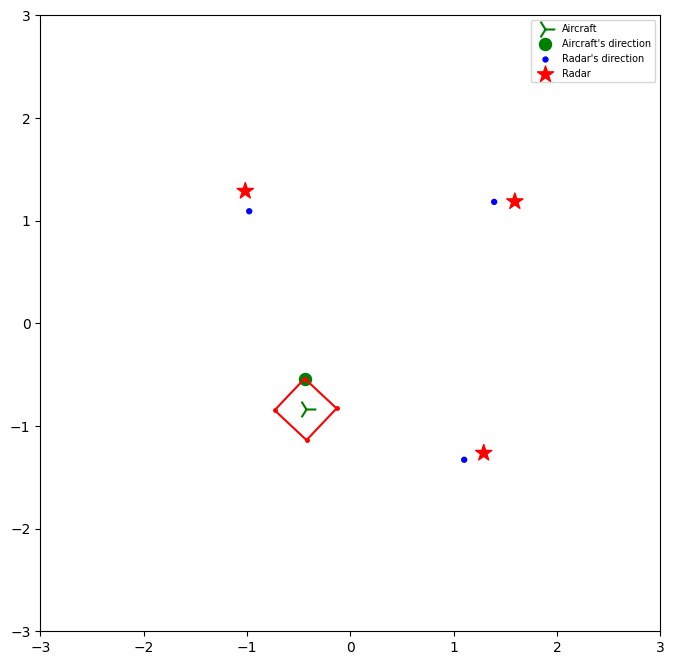

1


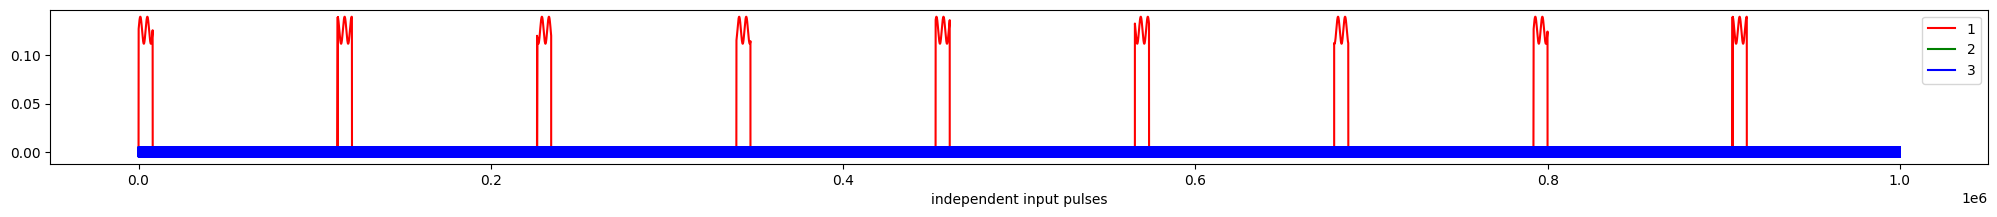

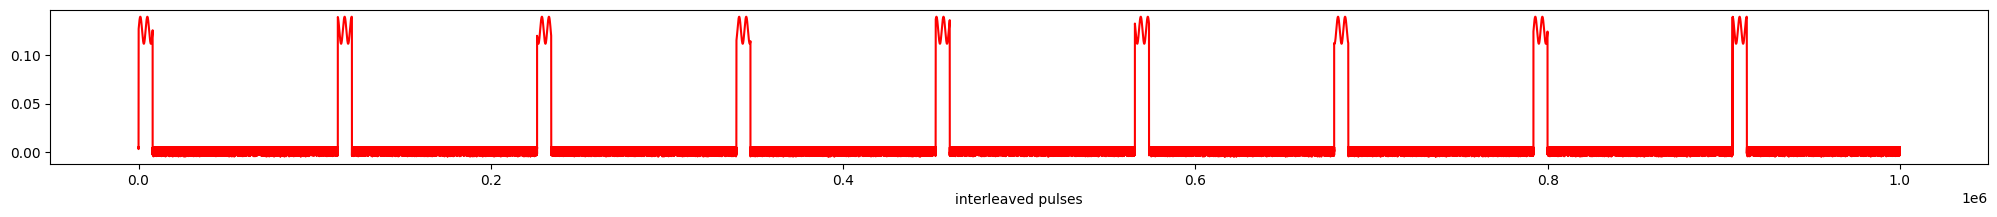

2


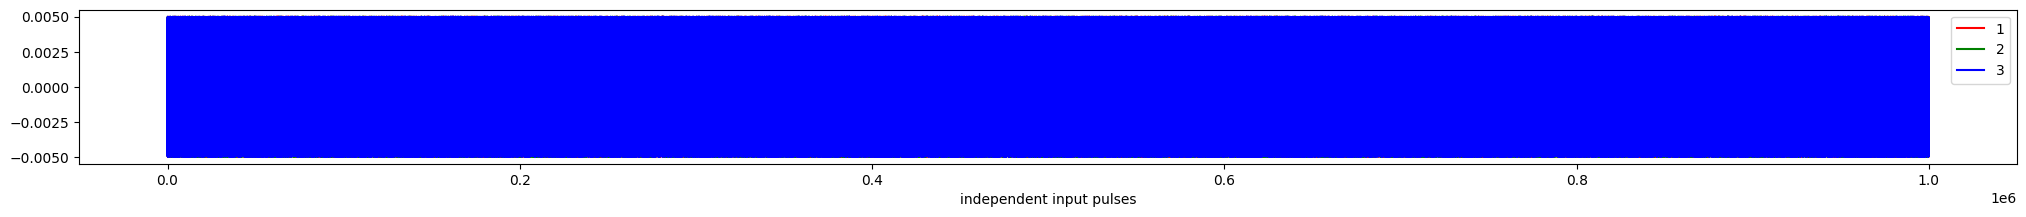

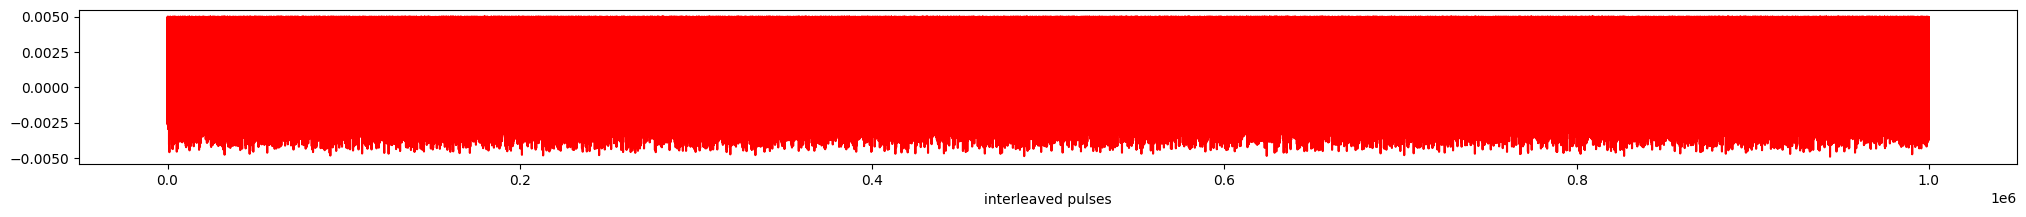

3


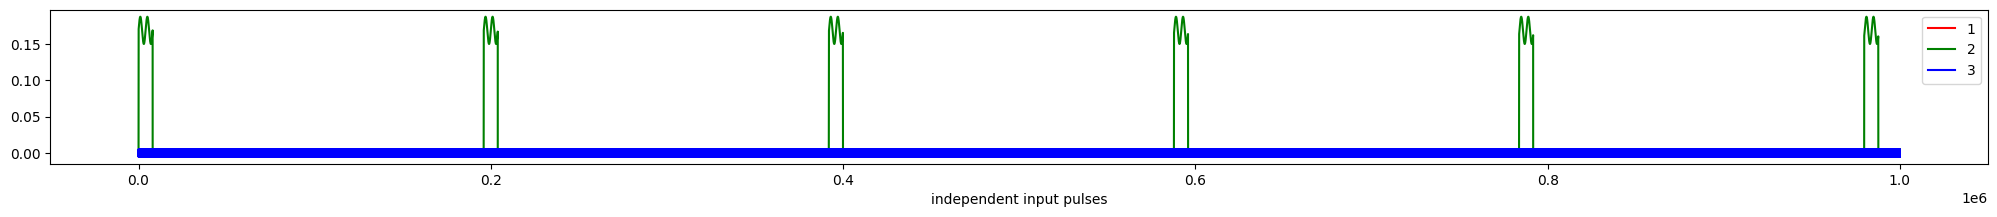

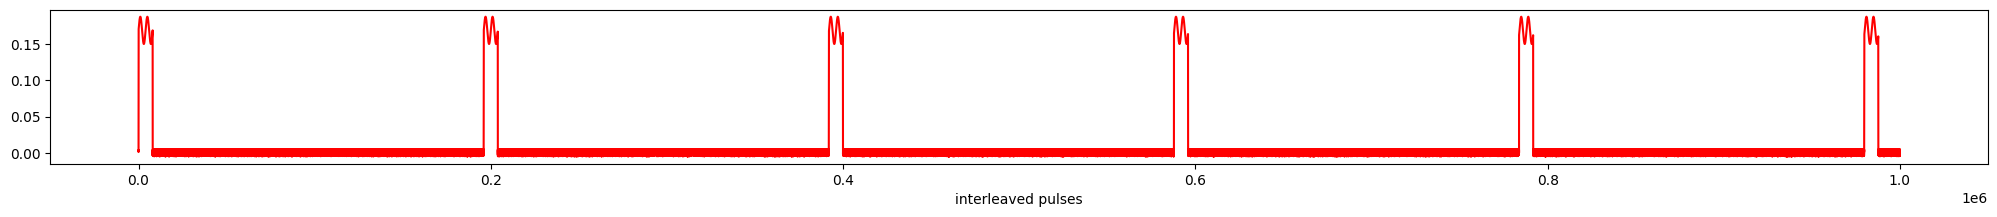

4


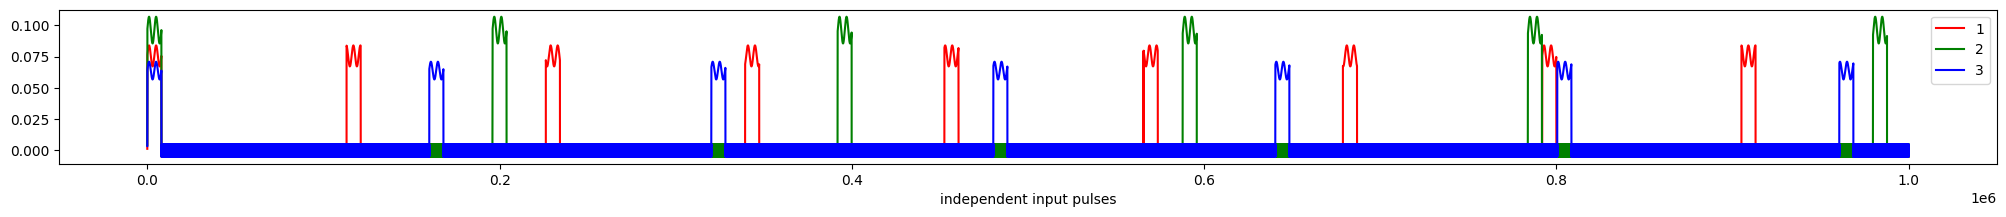

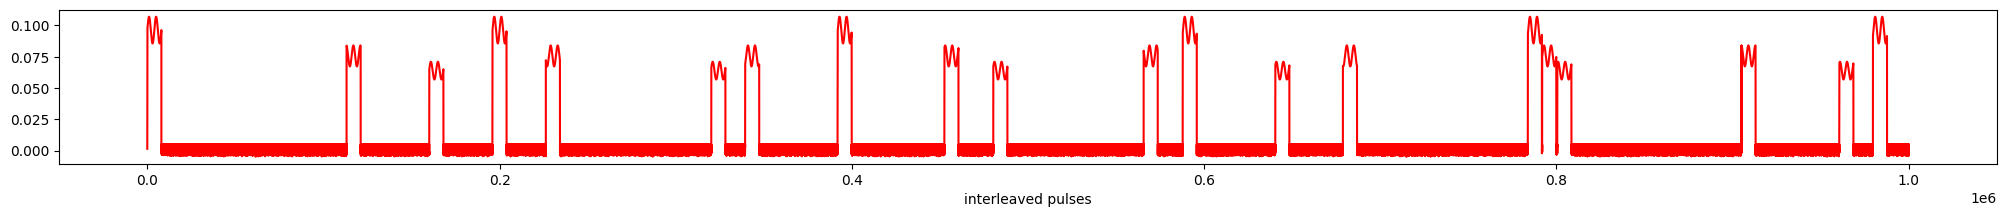

In [5]:
receivers_n=4                # Number of recievers on the aircraft
radars_n=3                   # Number of radars

radar_positions=[]
rad_range=[1,2]
for i in range(radars_n):
    radar_positions.append((random.uniform(rad_range[0],rad_range[1]) if random.uniform(-1,1)>0 else random.uniform(-rad_range[0],-rad_range[1]),
                            random.uniform(rad_range[0],rad_range[1]) if random.uniform(-1,1)>0 else random.uniform(-rad_range[0],-rad_range[1])))
radar_positions = np.array(radar_positions)

# radar_positions = np.array([
#     # (1,0),
#     (1,1),
#     # (0,1),
#     (-1,1),
#     # (-1,0),
#     # (-1,-1),
#     # (0,-1),
#     # (1,-1),
# ])

aircraft_0 = aircraft(id=0,pos=(0,0),heading=0,receivers=receivers_n)
aircraft_0 = aircraft(id=0,pos=(random.uniform(-1,1),random.uniform(-1,1)),heading=random.uniform(0,360),receivers=receivers_n)

radars=[]
pulses=[]                                   
for i in range(receivers_n):                          
    pulses.append([])

for j in range(radars_n):
    heading_angle=int(math.degrees(math.atan2(aircraft_0.pos[1]-radar_positions[j][1],aircraft_0.pos[0]-radar_positions[j][0])))#+180
    heading_noise_range=60
    radar_j = radar(id=j,pri=random.randint(100000, 200000),pwd=8000,pos=radar_positions[j],heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range))
    # radar_j = radar(id=j,pri=100000,pwd=9000,pos=radar_positions[j],heading=heading_angle)
    pulse_j = reciever(id=j,radar=radar_j,aircraft=aircraft_0)
    radars.append(radar_j)
    for i in range(receivers_n):
        pulses[i].append(pulse_j.pulse_train[i])
    del radar_j;
    del pulse_j;
    
plt.figure(figsize=(8 , 8))

tmp_s_r=0.2    
tmp_x_r=[]   
tmp_y_r=[]                        
for i in radars:
    tmp_x_r.append(i.pos[0]+(tmp_s_r*math.cos(math.radians(i.heading))))
    tmp_y_r.append(i.pos[1]+(tmp_s_r*math.sin(math.radians(i.heading))))
    
tmp_s_a=0.3    
tmp_x_a=[]   
tmp_y_a=[]                        
for j in range(receivers_n+1):
    tmp_x_a.append(aircraft_0.pos[0]+(tmp_s_a*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(2*j)/2))))
    tmp_y_a.append(aircraft_0.pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(2*j)/2))))
         
plt.scatter(aircraft_0.pos[0],aircraft_0.pos[1],[200], color='g', marker = '4',label='Aircraft')
plt.plot(tmp_x_a,tmp_y_a, color='r', marker = '.', markersize=5)
plt.scatter(tmp_x_a[0],tmp_y_a[0],[300], color='g', marker = '.',label='Aircraft\'s direction')
plt.scatter(tmp_x_r,tmp_y_r,[50]*len(tmp_x_r), color='b', marker = '.',label='Radar\'s direction')
plt.scatter(radar_positions[:,0],radar_positions[:,1],[150]*len(radar_positions), color='r', marker = '*',label='Radar')
plt.legend(fontsize = 7)
rng=3
for i in radar_positions:
    for j in i:
        if(rng<(abs(j)+1)):
            rng=abs(j)+1
plt.xlim([-rng, rng])
plt.ylim([-rng, rng])
# plt.savefig("main.jpg")
plt.show()
interleaved_pulse_train=interleave(pulses,display=1)

In [6]:
def pdw(pulse_f,display=1):
    global time,ci,cf,fig_x,fig_y,clrs
    # ci=849000
    # cf=853000
    pdw=[]
    idx=0
    for i in pulse_f:
        if(display):
            idx+=1
            print(idx)
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],i[ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            plt.show()
    tmp_pdw={}
    counter=[]
    max_amplitude=[]
    max_amplitude_t=[]
    list_init=[]
    fall_flag=[]
    lead_flag=[]
    increasing_count=[]
    increasing_flag=[]
    top_points=[]
    for j in pulse_f:
        counter.append(0)
        max_amplitude.append(0)
        max_amplitude_t.append(0)
        increasing_count.append(0)
        list_init.append([])
        top_points.append([])
        increasing_flag.append(0)
        fall_flag.append(True)
        lead_flag.append(True)
    for i in range(-1,len(time)-1):
        all_fall=0
        tmp_counter=[]
        tmp_amplitude=[]
        for j in range(len(pulse_f)):
            if(pulse_f[j][i]>base_noise_max):
                if not(lead_flag[j]):
                    lead_flag[j]=True # Rising edge
                    if(len(tmp_pdw)==0):
                        tmp_pdw['TOA']=i
                if(pulse_f[j][i]>max_amplitude[j]):
                    max_amplitude[j]=pulse_f[j][i]
                if(pulse_f[j][i]>=max_amplitude_t[j]):
                    max_amplitude_t[j]=pulse_f[j][i]
                    increasing_count[j]=0
                    increasing_flag[j]+=1
                    # if(i>133002-20 and i<137002+20):
                else:
                    # if(i>133002-20 and i<137002+20):
                    if (increasing_flag[j]>10):
                        increasing_count[j]+=1
                        if increasing_count[j]>10:
                            top_points[j].append(i-increasing_count[j])
                            max_amplitude_t[j]=0
                            increasing_flag[j]=0
                            increasing_count[j]=0
                counter[j]+=1
                fall_flag[j]=False
            else:
                if not(fall_flag[j]):
                    fall_flag[j]=True # Falling edge
                lead_flag[j]=False
                tmp_counter.append(counter[j])
                tmp_amplitude.append(max_amplitude[j])
                max_amplitude[j]=0
                max_amplitude_t[j]=0
                counter[j]=0
                all_fall+=1
        if(all_fall==len(pulse_f) and len(tmp_pdw)!=0):
            tmp_pdw['PWD']=max(tmp_counter)-1
            tmp_pdw['Frequency']=[]
            tmp_pdw['AOA']=0
            tmp_pdw['Freq_modulation_flag']=0
            tmp_pdw['Amplitude']=[]
            freq_app=True
            freq_mod=False
            Freq=0
            for j in range(len(pulse_f)):
                tmp_pdw['Amplitude'].append(tmp_amplitude[j])
                if(len(top_points[j])>0 and freq_app==True):
                    for k in range(len(top_points[j])-1):
                        top_points[j][k]=top_points[j][k+1]-top_points[j][k]
                    top_points[j]=top_points[j][:-1]
                    Freq=2000/np.mean(top_points[j])
                    freq_app=False
                    tmp_pdw['Frequency'].append(top_points[j])
                    # if(len(top_points[j][1:])>2):
                    #     for k in range(len(top_points[j])-1):
                    #         top_points[j][k]=top_points[j][k+1]-top_points[j][k]
                    #     top_points[j].pop(-1)
                    if np.std(top_points[j])>1:
                        if(len(top_points[j][1:])>1):
                            if(np.std(top_points[j][1:])>1):
                                print(np.std(top_points[j][1:]))
                                freq_mod=True
                        else:
                            freq_mod=True
                top_points[j]=[]
            tmp_pdw['Frequency']=Freq
            tmp_pdw['Freq_modulation_flag']=freq_mod
            pdw.append(tmp_pdw)
            tmp_pdw={}
    return pdw

pdws = pdw(interleaved_pulse_train,display=0)

In [7]:
# Doubt ask about pulse width of mixed pulses
# How to find AOA cause Gain is not a function of theta but taken from the table (Ampitude = (Pt*G(theta))/(4*pi*R^2))
for i in radars:
    print('Frequency of the radar id :',i.freq)
    break
print('PDW\'s of the recieved pulses are as follows')
for i in pdws[:]:
    print('---------------------------------')
    for j in list(i.keys()):
        print(j,':',i[j])

Frequency of the radar id : 0.5
PDW's of the recieved pulses are as follows
---------------------------------
TOA : 2
PWD : 8000
Frequency : 0.5
AOA : 0
Freq_modulation_flag : False
Amplitude : [0.13987200343845188, 0, 0.18713535049407085, 0.10698098211514774]
---------------------------------
TOA : 113136
PWD : 8000
Frequency : 0.5
AOA : 0
Freq_modulation_flag : False
Amplitude : [0.13987200343845188, 0, 0, 0.08404357857065327]
---------------------------------
TOA : 160102
PWD : 8000
Frequency : 0.5
AOA : 0
Freq_modulation_flag : False
Amplitude : [0, 0, 0, 0.07099079799533205]
---------------------------------
TOA : 195944
PWD : 8000
Frequency : 0.5
AOA : 0
Freq_modulation_flag : False
Amplitude : [0, 0, 0.18713535049407085, 0.10698098211514774]
---------------------------------
TOA : 226270
PWD : 8000
Frequency : 0.5
AOA : 0
Freq_modulation_flag : False
Amplitude : [0.13987200343845188, 0, 0, 0.08404357857065327]
---------------------------------
TOA : 320202
PWD : 8000
Frequency :